In [3]:
# Insert GCP Maps Services Static Map API key here
import os
os.environ['GMAP_KEY'] = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [4]:
from gmaploader.coordinates import Coordinates
from gmaploader.globalmaptiles import GlobalMercator
from gmaploader import GMapLoader

In [7]:
import pandas as pd
import json
import numpy as np
import glob
import PIL
from PIL import Image, ImageDraw, ImageFont
import h5py
import matplotlib.pyplot as plt
import os
import re
from matplotlib import cm as CM
import gaussian_functions as gf

# Download images

In [11]:
def generate_new_filename(i, j, old_filename):
    """Generates new filename that includes loc_id and photo_id
    
    Args:
        i (int): loc_id
        j (int): photo_id
    
    Returns:
        string
        
    Example
        >> generate_new_filename(5, 10, 'test_filename.csv')
        '05_10_test_filename.csv'
    """
    loc_id = str(i).rjust(2,'0')
    pic_id = str(j).rjust(2,'0')
    new_filename = f'{loc_id}_{pic_id}_{old_filename}'
    return new_filename

In [ ]:
latlon_lst = [
    # old 
    (51.5638, -0.1647),
    (51.4497, -0.3061),
    (51.4589, -0.2977),
    (51.4202, -0.2861),
    (51.5384, -0.0357),
    (51.5537, -0.0448),
    (51.5848, -0.0118),
    (51.5127, -0.152),
    (51.5433, -0.1647),
    (51.4311, -0.1231),
    (51.4403, 0.0273),
    (51.518, -0.0474),
    (51.5366, -0.1014),
    (51.541, -0.1201),
    (51.5833, -0.1727),
    (51.5378, -0.1391),
    (51.4578, -0.163),
    (51.4474, -0.2777),
    (51.3601, -0.4458),
    (51.429, -0.282),
    (51.4208, -0.1166),
    (51.4209, -0.0172),
    (51.4198, 0.0274),
    
    # newer, 23 onwards
    (51.431994, -0.267736),
    (51.434205, -0.279634),
    (51.433117, -0.250312),
    (51.431282, -0.221028),
    (51.463506, -0.054271),
    (51.533633, -0.006862),
    (51.565853, -0.043303),
    (51.436032, -0.074844),
    (51.354835, 0.029953),
    (51.333599, -0.061435)
]

zoom = 19

# Initalise GM
gm = GlobalMercator()

for i, (lat, lon) in enumerate(latlon_lst):
    # Get tile coordinates of lat lon
    coord = Coordinates(lat=lat, lon=lon, zoom=19)
    tile_x, tile_y = coord.tile_x, coord.tile_y
    
    # This part generates 4 images from a single lat lon coordinate
    # Each image is 4 google tiles wide (256 x 4 = 1024)
    # Get the same 1024x1024 size image, but 4 tiles right, down, and right and down
    interval = [0,4]
    j = 0
    for iy, y in enumerate(interval):
        for ix, x in enumerate(interval):
            
            # Get top left lat-lon coordinates
            lat_, lon_, _, _ = gm.TileLatLonBounds(tile_x+x, tile_y+y, 19)
            
            # Get image
            gml = GMapLoader(lat=lat_, lon=lon_, zoom=zoom, width=1024, height=1024, delete_temp=False)
            
            # Name files
            old_filename = gml.img_filename
            new_filename = generate_new_filename(i, j, old_filename)
            new_filepath = gml.img_filepath.replace(old_filename, new_filename)
            
            # Save
            gml.save(filepath=new_filepath)
            j+=1

## Get count of trees in each image

In [13]:
dct = {
    'filename': [],
    'count': []
}

# Get list of json filepaths
json_folder = os.path.join(os.getcwd(), 'jsons')
json_lst = [os.path.join(json_folder, x) for x in os.listdir(json_folder) if '.json' in x]

for json_filepath in json_lst:
    _, filename = os.path.split(json_filepath)
    
    # Open GT JSON
    with open(json_filepath) as f:
        json_dct = json.load(f)
    
    # Convert to array
    points = []
    for tree in json_dct['shapes']:
        points.append(tree['points'][0])
    points = np.array(points).astype(int)
    
    # Add to dict
    dct['filename'].append(filename)
    dct['count'].append(len(points))
    
df = pd.DataFrame(dct)
df

,filename,count
0,00_00_51.56383918_-0.16479492_19_1024_1024.json,27
1,00_02_51.56213176_-0.16479492_19_1024_1024.json,109
2,00_01_51.56383918_-0.16204834_19_1024_1024.json,49
3,00_03_51.56213176_-0.16204834_19_1024_1024.json,68
4,01_00_51.44972793_-0.3062439_19_1024_1024.json,44
...,...,...
127,32_00_51.33361478_-0.0617981_19_1024_1024.json,235
128,32_01_51.33361478_-0.05905151_19_1024_1024.json,153
129,32_02_51.33189872_-0.0617981_19_1024_1024.json,322
130,32_03_51.33189872_-0.05905151_19_1024_1024.json,209


### Total

In [14]:
df.sum(numeric_only=True)

count    13944
dtype: int64

## Convert JSONS to csvs

In [ ]:
# Get list of json filepaths
json_folder = os.path.join(os.getcwd(), 'jsons')
json_lst = [os.path.join(json_folder, x) for x in os.listdir(json_folder) if '.json' in x]

for json_filepath in json_lst:
    
    # Open JSON
    with open(json_filepath) as f:
        json_dct = json.load(f)
    
    # Extract array
    points = []
    for tree in json_dct['shapes']:
        points.append(tree['points'][0])
    
    # Convert to dataframe
    points_filepath = json_filepath.replace('jsons', 'gt_points').replace('.json', '.csv')
    _, points_filename = os.path.split(points_filepath)
    points = np.array(points).astype(int)
    df = pd.DataFrame(points)
    
    # Save to csv
    df.to_csv(points_filepath, header=None, index=None)
    print(points_filename, len(df))

## Example Image with annotation

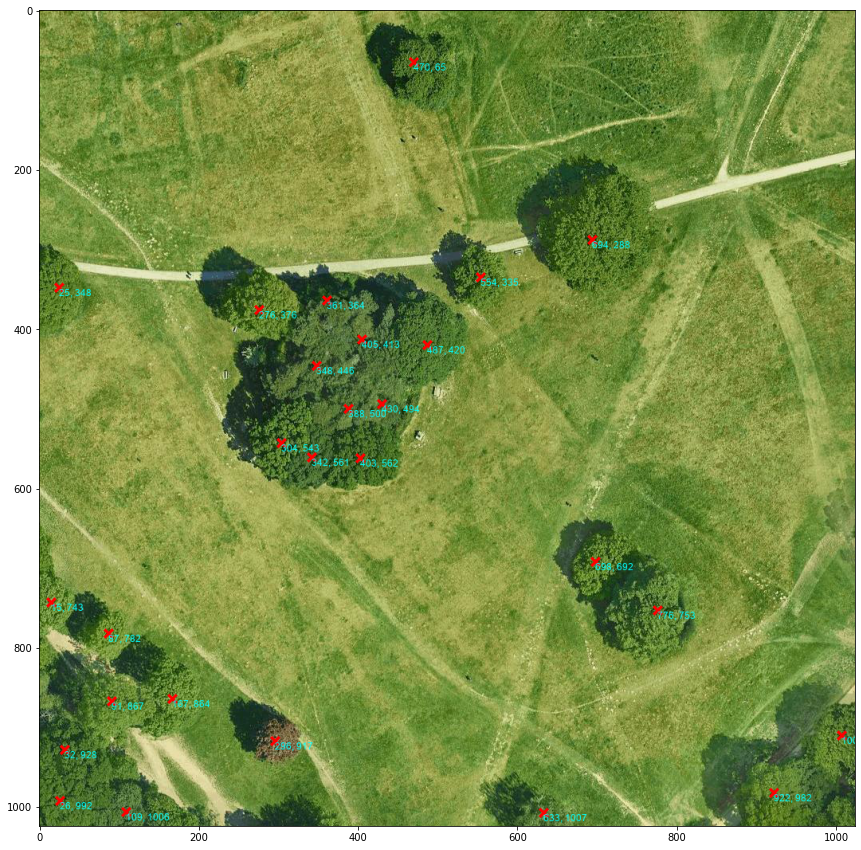

In [17]:
filename = '00_00_51.56383918_-0.16479492_19_1024_1024.jpg'

# Generate filepaths
img_filepath = os.path.join(os.getcwd(), 'img', filename)
points_filepath = os.path.join(os.getcwd(), 'gt_points', filename.replace('.jpg', '.csv'))

# Open points and image
points = pd.read_csv(points_filepath, header=None).values
im = Image.open(img_filepath)

draw = ImageDraw.Draw(im)
size = 5
width = 5

# Iterate over each point, draw an 'x'
for x, y in points:
    # 'x' coordinates
    left = max(x-size, 0)
    right = min(x+size, im.size[0])
    top = min(y+size, im.size[0])
    bottom = max(y-size, 0)
    
    # Annotate
    draw.line([(left, bottom), (right, top)], fill = 'red', width = width)
    draw.line([(left, top), (right, bottom)], fill = 'red', width = width)
    font = ImageFont.truetype("arial", 12)
    draw.text((x, y),f'{x}, {y}',(0,255,255), font=font)
    
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im)

# Generate density maps

## Generate GT points map

1024 x 1024 array, each tree represented by a 1

In [ ]:
file_lst = glob.glob(os.path.join(os.getcwd(), 'img', '*.jpg'))

for img_filename in file_lst:
    
    # Create filepaths
    img_filepath = os.path.join(os.getcwd(), 'img', img_filename)
    points_filepath = img_filepath.replace('img', 'gt_points').replace('.jpg', '.csv')
    
    # Get image size
    im = PIL.Image.open(img_filepath)
    width, height = im.size
    
    # Generate empty density map
    gt_map = np.zeros((height, width))
    
    # Open and apply points to map
    points = pd.read_csv(points_filepath, index_col=None, header=None).values
    for x, y in points:
        if x < width and y < height:
            gt_map[y, x]=1
        else:
            print(outside)
    
    # Save as .h5 file
    gt_map_path = img_filepath.replace('.jpg', '.h5').replace('img', 'gt_map_points')
    _, gt_map_filename = os.path.split(gt_map_path) 
    with h5py.File(gt_map_path, 'w') as hf:
        hf['gt_map'] = gt_map
        
    print(f'{gt_map_filename} saved.')

## Generate gaussian density map

As above, but gaussian kernel applied

### Get image and ground truth filepaths

In [22]:
root = os.path.join(os.getcwd(), 'img')

img_gt_paths = []
img_paths = glob.glob(os.path.join(root, '*.jpg'))

for img_path in img_paths:
    gt_path = img_path.replace('.jpg', '.csv').replace('img', 'gt_points')
    if os.path.exists(img_path):
        if os.path.exists(gt_path):
            img_gt_paths.append((img_path, gt_path))
        else:
            print(gt_path, 'doesnt exist')
    else:
        print(img_path, 'doesnt exist')

len(img_gt_paths)

132

In [ ]:
# Generate dictionary of all points for all images
points_dct = gf.generate_points_dct(img_gt_paths)

# Generate dictionary of gaussian kernels of varying sizes
kernels_dct = gf.generate_gaussian_kernels()

# Generate dictionary of distances to 3 nearest trees for each tree for each image
distances_dct = gf.compute_distances(points_dct)

In [ ]:
# === Params ===
min_sigma = 2  ## can be set 0
file = 'h5'
method=3 # 1 is relative, 3 is fixed
const_sigma = 15 # if fixed

# Generate files
gf.generate_gt_den_maps(
    img_gt_paths=img_gt_paths,
    points_dct=points_dct,
    distances_dct=distances_dct,
    kernels_dct=kernels_dct,
    method=method,
    file=file,
    const_sigma=const_sigma
)

## Visualise

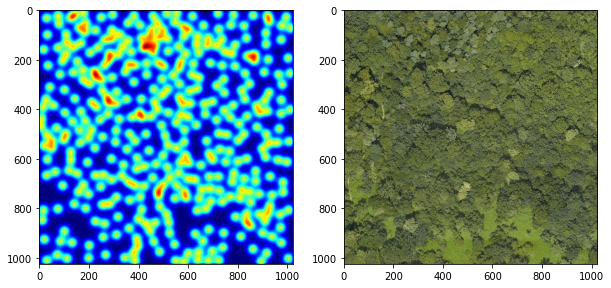

In [19]:
img_filepath, _ = img_gt_paths[127]

# Open image
img = PIL.Image.open(img_filepath)

# Open gt
gt_filepath = img_filepath.replace('.jpg','.h5').replace('img','gt_map_gaus')
gt_file = h5py.File(gt_filepath, 'r')
gt = np.asarray(gt_file['density'])

# Plot both
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(gt,cmap=CM.jet)
ax[1].imshow(img)

img.close()

## Normalisation

Get mean and standard deviations

In [20]:
from torch.utils import data
from PIL import Image
import torchvision

class London(data.Dataset):
    def __init__(self, data_files, main_transform):
        self.main_transform = main_transform
        self.data_files = data_files
        self.num_samples = len(self.data_files)

    def __getitem__(self, index):
        img_filepath = self.data_files[index]

        img = self.read_image(img_filepath)
        if self.main_transform is not None:
            img = self.main_transform(img)
        return img

    def __len__(self):
        return self.num_samples

    def read_image(self, img_filepath):
        img = Image.open(img_filepath)
        if img.mode == 'L':
            img = img.convert('RGB')
        return img

    def get_num_samples(self):
        return self.num_samples

dataset_lst = glob.glob(os.path.join(os.getcwd(), 'img', '*.jpg'))

transform = torchvision.transforms.ToTensor()
london = London(dataset_lst, transform)

loader = data.DataLoader(london,
                         batch_size=1,
                         num_workers=0,
                         shuffle=False)

mean = 0.
std = 0.
for images in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
mean, std

(tensor([0.4063, 0.4952, 0.3289]), tensor([0.1718, 0.1585, 0.1603]))

# Train test split

In [ ]:
# Generate list of img filepaths
file_lst = glob.glob(os.path.join('.', 'img', '*.jpg'))

# Add gt filepaths
file_lst = [[x, x.replace('img', 'gt_map_gaus').replace('.jpg', '.h5')] for x in file_lst]

# Check exists
for img, gt in file_lst:
    if not os.path.exists(img):
        print(f'{img} doesnt exist')
    if not os.path.exists(gt):
        print(f'{gt} doesnt exist')

In [ ]:
# Set train size
train_size = 0.7

# Convert list to dataframe
df = pd.DataFrame(file_lst)
df.columns = ['img_path', 'gt_path']

# Create test and val dataframes
df_train = df.sample(int(train_size*len(df)))
df_val = df[~df['img_path'].isin(df_train['img_path'])]

# Save
# df_train.to_csv('./data/train_filelist.csv')
# df_val.to_csv('./data/val_filelist.csv')

In [ ]:
# Load
df_train = pd.read_csv('./data/train_filelist.csv')
df_val = pd.read_csv('./data/val_filelist.csv')

# Split path, ignoring '.'
split = lambda x: [x for x in x.split(os.sep) if x != '.']

# Train json
df_train.loc[:,'img_path'] = df_train['img_path'].apply(split)
df_train.loc[:,'gt_path'] = df_train['gt_path'].apply(split)
train_lst = df_train.values.tolist()
with open('train.json', 'w') as f:
    json.dump(train_lst, f)

# Test json
df_val.loc[:,'img_path'] = df_val['img_path'].apply(split)
df_val.loc[:,'gt_path'] = df_val['gt_path'].apply(split)
val_lst = df_val.values.tolist()
with open('val.json', 'w') as f:
    json.dump(val_lst, f)

# Generate data about dataset

## Generate file summary

In [ ]:
dct = {
    'filename': [],
    'loc_id': [],
    'photo_id': [],
    'left': [],
    'top': [],
    'right': [],
    'bottom': [],
    'tile_x_tl': [],
    'tile_y_tl': [],
    'width': [],
    'height': [],
    'zoom': [],
    'count': [],
}

points_filelist = glob.glob(os.path.join(os.getcwd(), 'gt_points', '*.csv'))

# Initalise GM
gm = GlobalMercator()

for points_filepath in points_filelist:
    
    # Open and count number of trees
    count = len(pd.read_csv(points_filepath, header=None))

    _, points_filename = os.path.split(points_filepath)
    img_filename = points_filename.replace('.csv', '.jpg')
    
    # Extract information from filename
    pattern = "(\d{1,2})_(\d{1,2})_([-\d]{1,4}.\d{1,8})_([-\d]{1,4}.\d{1,8})_(\d{1,2})_(\d{1,4})_(\d{1,4})"
    loc_id, photo_id, lat_tl, lon_tl, zoom, width, height = re.findall(pattern, points_filepath)[0]
    lat_tl = float(lat_tl)
    lon_tl = float(lon_tl)
    zoom = int(zoom)
    width = int(width)
    height = int(height)
    
    # Get bottom right lat-lon coordinates
    coord = Coordinates(lat=lat_tl, lon=lon_tl, zoom=19)
    tile_x, tile_y = coord.tile_x, coord.tile_y
    lat_br, lon_br, _, _ = gm.TileLatLonBounds(tile_x+4, tile_y+4, 19)

    # Add to dict
    dct['filename'].append(img_filename)
    dct['loc_id'].append(loc_id)
    dct['photo_id'].append(photo_id)
    dct['left'].append(lon_tl)
    dct['top'].append(lat_tl)
    dct['right'].append(lon_br)
    dct['bottom'].append(lat_br)
    dct['tile_x_tl'].append(tile_x)
    dct['tile_y_tl'].append(tile_y)
    dct['width'].append(width)
    dct['height'].append(height)
    dct['zoom'].append(zoom)
    dct['count'].append(count)

df = pd.DataFrame(dct)
df

### Save

In [ ]:
# df.to_csv('./data/file_summary.csv', index=None)

## List lat-lon of each tree

In [ ]:
df_all = pd.DataFrame()

points_filelist = glob.glob(os.path.join(os.getcwd(), 'gt_points', '*.csv'))
for points_filepath in points_filelist:
    _, points_filename = os.path.split(points_filepath)
    img_filename = points_filename.replace('.csv', '.jpg')
    
    # Extract information from picture name
    pattern = "\d{1,2}_\d{1,2}_([-\d]{1,4}.\d{1,8})_([-\d]{1,4}.\d{1,8})_(\d{1,2})_\d{1,4}_\d{1,4}"
    lat_tl, lon_tl, zoom = re.findall(pattern, points_filepath)[0]
    lat_tl = float(lat_tl)
    lon_tl = float(lon_tl)
    zoom = int(zoom)

    # Get lat-lon per pixel
    coord = Coordinates(lat=lat_tl, lon=lon_tl, zoom=zoom)
    lat_pxl = coord.lat_pxl
    lon_pxl = coord.lon_pxl

    # Open ground truth points
    df = pd.read_csv(points_filepath, header=None)
    df.columns = ['x', 'y']
    
    # Calculate lat-lon for each tree
    df['lat'] = lat_tl - (df['y'] * lat_pxl)
    df['lon'] = (df['x'] * lon_pxl) + lon_tl
    
    df['filename'] = img_filename
    
    df_all = pd.concat([df_all, df], axis=0)
    
df_all

### Save

In [ ]:
# df_all.to_csv('./data/tree_latlon.csv', index=None)